# Описание

В данном ноутбуке проводятся эксперименты по распознаванию лиц с пакетом facenet_pytorch (https://github.com/timesler/facenet-pytorch).

Собран датасет на 3 конкретные персоны (p,n,b) и все остальные персоны (o). В p,n,b по 20 изображений в o - 150.

На базе facenet-pytorch тренируется классификатор на 4 класса.

Проводится тестирование на 30 изображениях (метрика - Accuracy).


# Preporation

In [59]:
# First we need to mount the Google drive 
import os
from google.colab import drive
drive.mount('/content/gdrive')
# Here specify the path to your directory
path ='/content/gdrive/MyDrive/Colab Notebooks/faceDetection/'
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

fatal: destination path 'facenet_pytorch' already exists and is not an empty directory.


# Module import

In [45]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

batch_size = 32
epochs = 8
workers = 2


Running on device: cuda:0


# 1 stage - Face detection
Первый шаг - найти лица на фото. Используем MTCNN (сеть в пакете facenet_pytorch).
Берем фото из одной директории и сохраняем лица в другую

In [27]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
path_in='/content/gdrive/MyDrive/Colab Notebooks/faceDetection/data_faces/raw_images/'
path_out='/content/gdrive/MyDrive/Colab Notebooks/faceDetection/data_faces/detect_faces/'

dataset = datasets.ImageFolder(path_in, transform=transforms.Resize((512, 512)))
dataset.samples = [
  (p, p.replace(path_in, path_out))
      for p, _ in dataset.samples
]
      
loader = DataLoader(
  dataset,
  num_workers=workers,
  batch_size=batch_size,
  collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
  mtcnn(x, save_path=y)
  print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn
#display(Image.open(path_out+'b1.jpg'))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/gdrive/MyDrive/Colab Notebooks/faceDetection/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/content/gdrive/MyDrive/Colab Notebooks/faceDetection/facenet_pytorch/models/mtcnn.py:339: VisibleDe

Batch 8 of 8

# Examples of detected faces

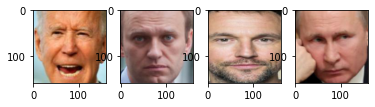

In [41]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

examples = [dataset.samples[0][1],dataset.samples[23][1],dataset.samples[42][1],dataset.samples[212][1]]

fig = figure()
for i,ex in enumerate(examples):
  a=fig.add_subplot(1,4,i+1)
  image = imread(ex)
  imshow(image,cmap='Greys_r')


#2 Stage train classifier 

С помощью предобученной InceptionResnetV1 получим эмбединги лиц и на их основании обучим классификатор (последний полносвязный слой).

Сеть была обучена с использованием TripletLoss, поэтому эмбединги лица конкретного человека должны распологаться компактно в пространстве и быть достаточно хорошо линейно разделимы.

In [42]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=4
).to(device)

## Data preparation

In [46]:
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
#scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(path_out, transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

## Training


In [49]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [50]:
print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer,
        batch_metrics=metrics, show_running=True, device=device
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device
    )




Initial
----------
Valid |     2/2    | loss:    0.1233 | fps:  289.2777 | acc:    0.9487   

Epoch 1/8
----------
Train |     6/6    | loss:    0.0107 | fps:  271.6696 | acc:    1.0000   
Valid |     2/2    | loss:    0.1057 | fps:  344.0584 | acc:    0.9688   

Epoch 2/8
----------
Train |     6/6    | loss:    0.0089 | fps:  275.4860 | acc:    1.0000   
Valid |     2/2    | loss:    0.1269 | fps:  342.9330 | acc:    0.9487   

Epoch 3/8
----------
Train |     6/6    | loss:    0.0079 | fps:  273.4686 | acc:    1.0000   
Valid |     2/2    | loss:    0.0895 | fps:  343.9218 | acc:    0.9688   

Epoch 4/8
----------
Train |     6/6    | loss:    0.0086 | fps:  281.6651 | acc:    1.0000   
Valid |     2/2    | loss:    0.0804 | fps:  330.8679 | acc:    0.9688   

Epoch 5/8
----------
Train |     6/6    | loss:    0.0106 | fps:  286.1107 | acc:    1.0000   
Valid |     2/2    | loss:    0.1144 | fps:  329.3585 | acc:    0.9487   

Epoch 6/8
----------
Train |     6/6    | loss:    0.0

# Testing

In [63]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
mtcnn.to(device)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

In [90]:
resnet.eval()
image_folder=path+'data_faces/faces_test'
transf=transforms.Compose([transforms.Resize((512, 512))])
correct=0
for img_name in os.listdir(image_folder):
  img=Image.open(image_folder+'/'+img_name)
  img=transf(img)
  res=mtcnn(img).to(device)
  img_probs = torch.nn.functional.softmax(resnet(res.unsqueeze(0)), dim=1)
  ind=torch.argmax(img_probs).cpu().numpy()
  img_prob=img_probs[0,ind].detach().cpu().numpy()
  if (img_name[0] == dataset.classes[ind]): correct+=1
  print('img: {0}, class: {1}, prob: {2:.2f}'.format(img_name,dataset.classes[ind],img_prob))

len_test=len(os.listdir(image_folder))
print()
print ('correct num: {0}, total num: {1}, accuracy: {2:.2f}'.format(correct,len_test,correct/len_test))

img: o2.jpg, class: o, prob: 0.99
img: p2.jpg, class: p, prob: 1.00
img: b2.jpg, class: b, prob: 0.95
img: p1.jpg, class: p, prob: 1.00
img: o1.jpg, class: o, prob: 1.00
img: n1.jpg, class: n, prob: 1.00
img: b1.jpg, class: b, prob: 0.79
img: p3.jpg, class: p, prob: 1.00
img: p4.jpg, class: p, prob: 1.00
img: p5.jpg, class: p, prob: 0.98
img: b3.jpg, class: b, prob: 0.98
img: b4.jpg, class: b, prob: 1.00
img: b5.jpg, class: b, prob: 0.98
img: o4.jpg, class: o, prob: 0.99
img: o5.jpg, class: o, prob: 0.99
img: o6.jpg, class: o, prob: 0.99
img: o9.jpg, class: o, prob: 0.98
img: n2.jpg, class: n, prob: 1.00
img: n3.jpg, class: n, prob: 1.00
img: n4.jpg, class: o, prob: 0.88
img: n5.jpg, class: n, prob: 1.00
img: n6.jpg, class: n, prob: 0.99
img: n7.jpg, class: o, prob: 0.68
img: n8.jpg, class: n, prob: 0.95
img: n10.jpg, class: o, prob: 0.91
img: n9.jpg, class: n, prob: 1.00

correct num: 23, total num: 26, accuracy: 0.88


# Выводы:

1. Значение Accuracy достаточно высокое, однако метрика является очень общей. Необходимо рассмотреть комплексную метрику на базе Precision/Recall.

2. Датасет достаточно мал. Необходимо обучать модель на большем датасете.

3. В класс 'o' попадают иные персоны и, возможно, тренировка в таком виде не совсем корректна. Возможно стоит обучить три бинарных классификатора для каждой персоны (один класс - изображения персоны, другой - все остальные изображения). На основаниии probe каждого классификатора и treshold определять, есть ли персона на изображении.

4. Поскольку используется предобученная модель, которая была обучена с TripletLoss, поробовать использовать метрику близости l2-distance и treshold для определения принадлежности классу.